## VAE+Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [79]:
# DNN for regression: inputs from the latent variables space of a VAE, outputs the solar, wind and hydro production over the chosen time-window

import optuna # to perform a grid search
import torch.optim as optim


class VAE(nn.Module): # VAE inherits from nn.Module, base class for neural network modules in PyTorch.
    def __init__(self, input_dim, hidden_dim1,latent_dim, hidden_dim2, activation):
        super(VAE, self).__init__() # to call init method on the parent class of VAE (nn.Module) so that is has all the same functions

        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1) # hidden_dim: hidden layer neurons of encoder NN
       # self.batch1 =  nn.BatchNorm1d(hidden_dim1)
        self.fc_mu = nn.Linear(hidden_dim1, latent_dim) # latent_dim : output layer neurons of encoder NN
        self.fc_logvar = nn.Linear(hidden_dim1, latent_dim)

        # decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim2)
       # self.batch2 =  nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, input_dim)
        self.activation = activation

    def encode(self, x):
        #h1 = self.activation(self.batch1(self.fc1(x)))
        h1 = self.activation((self.fc1(x)))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar): # reparametrization trick to allow backpropagation
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        #h = self.activation(self.batch2(self.fc2(z)))
        h = self.activation((self.fc2(z)))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z  # z are the latent representations of the input x


# VAE loss function (separate function, not class method)
def vae_loss(recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD, MSE, KLD



class Net(nn.Module):
    def __init__(self,Ni,N1,N2,No,activation): # Ni is the dimension of z, N1 the number of hidden neurons of the first layer, N2 the number of hidden neurons of the second layer
        super(Net,self).__init__()

        self.fc1 = nn.Linear(Ni,N1)
        self.batch1 =  nn.BatchNorm1d(N1)
        self.fc2 = nn.Linear(N1,N2)
        self.batch2 =  nn.BatchNorm1d(N2)
        self.out = nn.Linear(N2,No)
        self.act = activation


    def forward(self,z): # input from latent variables
            #h1= self.act(self.batch1(self.fc1(z)))
            #h2 = self.act(self.batch2(self.fc2(h1)))
            h1= self.act((self.fc1(z)))
            h2 = self.act((self.fc2(h1)))
            out = F.relu(self.out(h2))
            return (out)


    def regr_loss(self,y,output,lambda_tik):
        mse = F.mse_loss(output, y)

        w_norm = 0.0
        for param in self.parameters():
            w_norm += torch.sum(torch.abs(param))

        return mse + lambda_tik*w_norm**2




# here we define the full network architecture for VAE+regression

class VAE_Regression(nn.Module):
    def __init__(self,input_dim, hidden_dim1,latent_dim,hidden_dim2,vae_activation,N1,N2,No,activation,lambda_tik):
        super(VAE_Regression,self).__init__()

        self.vae = VAE(input_dim, hidden_dim1,latent_dim, hidden_dim2, vae_activation)
        self.regression = Net(latent_dim,N1,N2,No,activation)

    def forward(self,x):
        reconstructed_x, mu, logvar, z = self.vae(x) # self.vae(x) is equivalent to calling self.vae.forward(x) thanks to nn.Module
        regr_output = self.regression(z)
        return(regr_output,reconstructed_x, mu, logvar,z)

    def VAE_loss(self,reconstructed_x, x, mu, logvar): # here VAE_loss/regression_loss are methods of the VAE_Regression class to be accessed later
        return(vae_loss(reconstructed_x, x, mu, logvar))

    def regression_loss(self,y,regr_output,lambda_tik):
        return(self.regression.regr_loss(y,regr_output,lambda_tik))




## Training and test dataset  

In [68]:
df_features = pd.read_csv('/home/lcpb_files/IT_NORD_VAE_input_new.csv') # vae input (input features X)
df_labels = pd.read_csv('/home/lcpb_files/normalized_actuals.csv') # regression training/test
df_labels= df_labels[['date_time','time','detrended_solar','detrended_wind','detrended_hydro']]
df_labels

,date_time,time,detrended_solar,detrended_wind,detrended_hydro
0,2022-01-01 00:00:00+00:00,0.000000,0.0,0.011976,0.099338
1,2022-01-01 01:00:00+00:00,0.000038,0.0,0.131732,0.095132
2,2022-01-01 02:00:00+00:00,0.000076,0.0,0.131728,0.094595
3,2022-01-01 03:00:00+00:00,0.000114,0.0,0.131724,0.097458
4,2022-01-01 04:00:00+00:00,0.000152,0.0,0.131720,0.094236
...,...,...,...,...,...
26371,2024-12-31 22:45:00+00:00,0.999848,0.0,0.265070,0.107815
26372,2024-12-31 23:00:00+00:00,0.999886,0.0,0.037867,0.019329
26373,2024-12-31 23:15:00+00:00,0.999924,0.0,0.037867,0.018974
26374,2024-12-31 23:30:00+00:00,0.999962,0.0,0.033134,0.017910


In [69]:
df_features

,Unnamed: 0,year_t0,2t_t0,solar_t0,tp_t0,ws_10m_t0,ws_100m_t0,hour_sin_t0,hour_cos_t0,day_sin_t0,...,ws_100m_t8,hour_sin_t8,hour_cos_t8,day_sin_t8,day_cos_t8,month_sin_t8,month_cos_t8,sin_dayofyear_t8,cos_dayofyear_t8,timestamp
0,0,-1.224855,-1.266622,-0.785197,-0.540314,-0.169929,0.237315,0.249009,1.890047,0.280164,...,-1.132097,-0.685682,1.408711,0.280448,1.400505,0.702453,1.109234,0.025586,1.291842,2022-01-01 00:00:00
1,1,-1.224855,-1.324489,-0.785197,-0.540314,-0.167036,0.001132,1.183829,1.408519,0.280164,...,-0.931334,0.249115,1.890286,0.552704,1.314595,0.702453,1.109234,0.050415,1.291222,2022-01-01 03:00:00
2,2,-1.224855,-1.363120,-0.691746,-0.543042,-0.218606,-0.093139,1.571044,0.246007,0.280164,...,-0.778698,1.183912,1.408711,0.552704,1.314595,0.702453,1.109234,0.050415,1.291222,2022-01-01 06:00:00
3,3,-1.224855,-1.091436,0.355950,-0.543042,-0.396948,-0.530006,1.183829,-0.916506,0.280164,...,-0.664870,1.571118,0.246088,0.552704,1.314595,0.702453,1.109234,0.050415,1.291222,2022-01-01 09:00:00
4,4,-1.224855,-0.496955,0.545301,-0.543042,-0.719834,-0.962998,0.249009,-1.398034,0.280164,...,-0.452988,1.183912,-0.916535,0.552704,1.314595,0.702453,1.109234,0.050415,1.291222,2022-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,8315,1.224561,-0.453550,-0.478673,-0.546437,-1.220757,-1.408609,-0.685811,-0.916506,-0.287572,...,-1.518295,0.249115,-1.398110,-0.003431,1.429539,-0.019310,1.295919,0.000749,1.292048,2024-12-30 15:00:00
8316,8316,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.287572,...,-1.388240,-0.685682,-0.916535,-0.003431,1.429539,-0.019310,1.295919,0.000749,1.292048,2024-12-30 18:00:00
8317,8317,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.287572,...,-1.439442,-1.072887,0.246088,-0.003431,1.429539,-0.019310,1.295919,0.000749,1.292048,2024-12-30 18:00:00
8318,8318,1.224561,-1.322641,-0.785197,-0.545773,-1.180936,-1.527834,-0.685811,1.408519,-0.287572,...,-1.439442,-1.072887,0.246088,-0.003431,1.429539,-0.019310,1.295919,0.000749,1.292048,2024-12-30 21:00:00


In [70]:
# we use as temporal info the day of the year (1...365)
features = ['day_sin_t0','day_cos_t0',
           'day_sin_t1','day_cos_t1',
           'day_sin_t2','day_cos_t2',
           'day_sin_t3','day_cos_t3',
           'day_sin_t4','day_cos_t4',
           'day_sin_t5','day_cos_t5',
           'day_sin_t6','day_cos_t6',
           'day_sin_t7','day_cos_t7',
           'day_sin_t8','day_cos_t8',
           'month_sin_t0','month_cos_t0',
           'month_sin_t1','month_cos_t1',
           'month_sin_t2','month_cos_t2',
           'month_sin_t3','month_cos_t3',
           'month_sin_t4','month_cos_t4',
           'month_sin_t5','month_cos_t5',
           'month_sin_t6','month_cos_t6',
           'month_sin_t7','month_cos_t7',
           'month_sin_t8','month_cos_t8',
            'Unnamed: 0']

# in alternative one can use the following lines to keep day and month time info
'''
features = ['sin_dayofyear_t0','cos_dayofyear_t0',
            'sin_dayofyear_t1','cos_dayofyear_t1',
            'sin_dayofyear_t2','cos_dayofyear_t2',
            'sin_dayofyear_t3','cos_dayofyear_t3',
            'sin_dayofyear_t4','cos_dayofyear_t4',
            'sin_dayofyear_t5','cos_dayofyear_t5',
            'sin_dayofyear_t6','cos_dayofyear_t6',
            'sin_dayofyear_t7','cos_dayofyear_t7',
            'sin_dayofyear_t8','cos_dayofyear_t8','Unnamed: 0'] '''

df_features = df_features.drop(columns = features)

In [71]:
df_features # methereological data every 3 hours, running over the course of a day  (10 features every 3 hour = 90 features)

,year_t0,2t_t0,solar_t0,tp_t0,ws_10m_t0,ws_100m_t0,hour_sin_t0,hour_cos_t0,sin_dayofyear_t0,cos_dayofyear_t0,...,2t_t8,solar_t8,tp_t8,ws_10m_t8,ws_100m_t8,hour_sin_t8,hour_cos_t8,sin_dayofyear_t8,cos_dayofyear_t8,timestamp
0,-1.224855,-1.266622,-0.785197,-0.540314,-0.169929,0.237315,0.249009,1.890047,0.025562,1.291842,...,-1.279364,-0.785204,-0.539696,-0.982129,-1.132097,-0.685682,1.408711,0.025586,1.291842,2022-01-01 00:00:00
1,-1.224855,-1.324489,-0.785197,-0.540314,-0.167036,0.001132,1.183829,1.408519,0.025562,1.291842,...,-1.305169,-0.785204,-0.539696,-0.791966,-0.931334,0.249115,1.890286,0.050415,1.291222,2022-01-01 03:00:00
2,-1.224855,-1.363120,-0.691746,-0.543042,-0.218606,-0.093139,1.571044,0.246007,0.025562,1.291842,...,-1.369257,-0.785204,-0.539696,-0.709343,-0.778698,1.183912,1.408711,0.050415,1.291222,2022-01-01 06:00:00
3,-1.224855,-1.091436,0.355950,-0.543042,-0.396948,-0.530006,1.183829,-0.916506,0.025562,1.291842,...,-1.427837,-0.704916,-0.537695,-0.616626,-0.664870,1.571118,0.246088,0.050415,1.291222,2022-01-01 09:00:00
4,-1.224855,-0.496955,0.545301,-0.543042,-0.719834,-0.962998,0.249009,-1.398034,0.025562,1.291842,...,-1.170501,0.196247,-0.537695,-0.573833,-0.452988,1.183912,-0.916535,0.050415,1.291222,2022-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,1.224561,-0.453550,-0.478673,-0.546437,-1.220757,-1.408609,-0.685811,-0.916506,-0.024044,1.291843,...,-0.518011,0.586399,-0.545575,-1.441098,-1.518295,0.249115,-1.398110,0.000749,1.292048,2024-12-30 15:00:00
8316,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.024044,1.291843,...,-0.567924,-0.485478,-0.545575,-1.249467,-1.388240,-0.685682,-0.916535,0.000749,1.292048,2024-12-30 18:00:00
8317,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.024044,1.291843,...,-1.247314,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,0.000749,1.292048,2024-12-30 18:00:00
8318,1.224561,-1.322641,-0.785197,-0.545773,-1.180936,-1.527834,-0.685811,1.408519,-0.024044,1.291843,...,-1.247314,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,0.000749,1.292048,2024-12-30 21:00:00


In [72]:
#Here we define the labels: (mean_solar, mean_wind, mean_hydro production) over the time window of 3 hours

df_labels['date_time'] = pd.to_datetime(df_labels['date_time']).dt.tz_localize(None)
df_features['timestamp'] = pd.to_datetime(df_features['timestamp']).dt.tz_localize(None)

df_labels.set_index('date_time', inplace=True)

y_list = []

# for every row of df_features
for ts in df_features['timestamp']:
    # time window: from t to t + 3h , we will input meteo data of a 6h window and predict energy prodcution of the last 3h of that window
    window_start = ts + pd.Timedelta(hours=3)
    window_end = ts + pd.Timedelta(hours=6)

    # select production rows in this time window
    window_data = df_labels.loc[window_start:window_end]

    # determine the average in this window
    if not window_data.empty:
        mean_vals = window_data[['detrended_solar', 'detrended_wind', 'detrended_hydro']].mean().values
    else:
        mean_vals = [float('nan'), float('nan'), float('nan')]  # se non ci sono dati in quella finestra

    y_list.append(mean_vals)

y_df = pd.DataFrame(y_list, columns=['mean_solar', 'mean_wind', 'mean_hydro'])



In [73]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#y_df = pd.DataFrame(scaler.fit_transform(y_df), columns=y_df.columns, index=y_df.index)
#df_training = pd.concat([df_features, y_df], axis=1) # full training dataset (both X,Y)
y_df

,mean_solar,mean_wind,mean_hydro
0,0.000000,0.128724,0.103141
1,0.027777,0.085309,0.116900
2,0.094022,0.125706,0.104819
3,0.048104,0.125694,0.114036
4,0.000590,0.125682,0.174220
...,...,...,...
8315,0.000000,0.057984,0.170083
8316,0.000000,0.023667,0.110943
8317,0.000000,0.023667,0.110943
8318,0.000000,0.006554,0.093944


In [74]:
from sklearn.model_selection import train_test_split


X_array = df_features.drop(columns=['timestamp']).iloc[:,0:20].values
Y_array = y_df.values if isinstance(y_df, pd.DataFrame) else y_df

n_samples = len(X_array)
split_idx = int(n_samples * 0.8)


X_train = X_array[:split_idx]
X_test = X_array[split_idx:] # we do not randomly split into training and test set to avoid replicating data across both (it's a time-series with sliding windows)

Y_train = Y_array[:split_idx]
Y_test = Y_array[split_idx:]

# keep track of the original indices and timestamps
idx_train = df_features.index[:split_idx] # to retrieve date/time at test time (for predictions)
idx_test = df_features.index[split_idx:]

test_timestamps = df_features.loc[idx_test, 'timestamp'].reset_index(drop=True)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# create a DataLoader for batching (training time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [75]:

X_train_tensor.shape

torch.Size([6656, 20])

tensor([[0.0000e+00, 1.3505e-01, 5.2357e-01],
        [0.0000e+00, 1.2231e-01, 4.5279e-01],
        [0.0000e+00, 1.2152e-01, 4.3807e-01],
        ...,
        [4.3221e-06, 2.9858e-01, 2.3688e-01],
        [1.9427e-06, 3.2397e-01, 2.1715e-01],
        [2.2274e-06, 3.5189e-01, 2.4829e-01]])


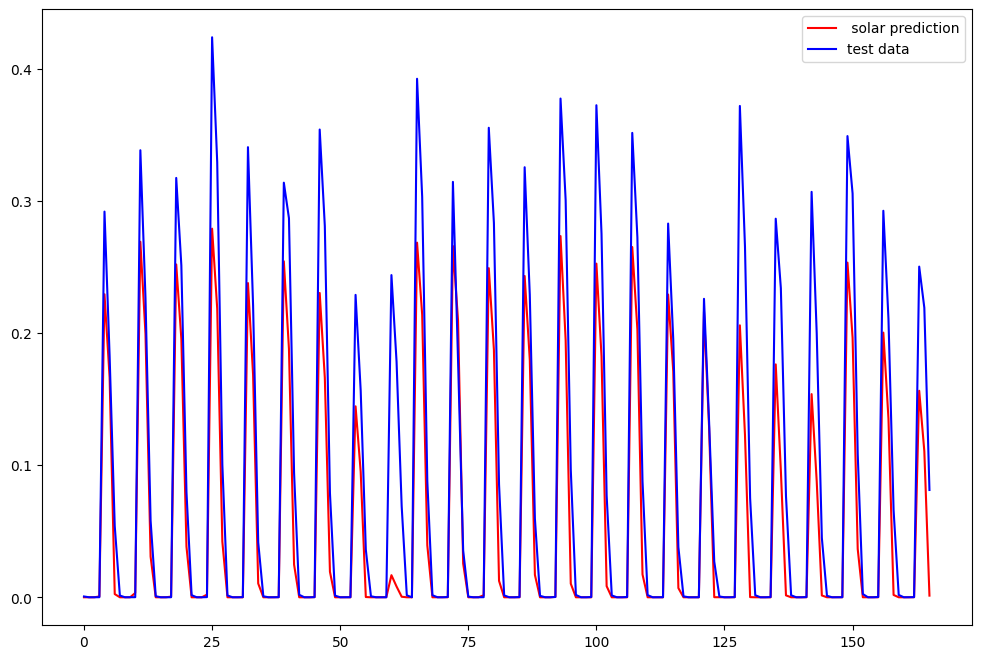

In [85]:
def train(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0.0
    total_vae_loss = 0.0
    total_regr_loss = 0.0

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # forward pass
        regr_output,recon_x, mu, logvar,z = model(data)

        # compute losses
        vae_loss_val, _, _ = model.VAE_loss(recon_x, data, mu, logvar)
        regr_loss_val = model.regression_loss(target, regr_output,lambda_tik)

        loss = regr_loss_val  # small beta to focus on minizmizing regression loss (or just use regr_loss)

        loss.backward()
        optimizer.step() # updates weights with gradients/parameters found


        total_loss += loss.item()
        total_vae_loss += vae_loss_val.item()
        total_regr_loss += regr_loss_val.item()

         # average losses over all batches
    avg_loss = total_loss / len(train_loader)
    avg_vae_loss = total_vae_loss / len(train_loader)
    avg_regr_loss = total_regr_loss / len(train_loader)

    return avg_loss, avg_vae_loss, avg_regr_loss


input_dim = X_train_tensor.shape[1] # number of input features
latent_dim = 8 #4
hidden_dim1 = 16 #16
hidden_dim2 = 16 #16
N1 = 8
N2 = 8
No = Y_train_tensor.shape[1]  # 3 outputs (solar, wind, hydro)
activation_fn = nn.LeakyReLU ()
lambda_tik = 3.42*10**-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_Regression(input_dim, hidden_dim1, latent_dim,hidden_dim2, activation_fn, N1, N2,No,activation_fn,lambda_tik).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00659)


loss = train(model,train_loader , optimizer, device)
model.eval()

test_predictions=[]
with torch.no_grad(): # disable gradient calculation for inference
    for i in range(10000):
      regr_output, reconstructed_x, mu, logvar, z = model(X_test_tensor.to(device))
      test_predictions.append(regr_output)  # shape: [100, test_size, 3]

test_predictions_tensor = torch.stack(test_predictions)

# compute mean across the 100 runs: shape becomes [test_size, 3]
mean_test_predictions = test_predictions_tensor.mean(dim=0)


z = z.cpu().numpy()
recon_x_test = reconstructed_x.cpu().numpy()

print(mean_test_predictions)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(int(len(mean_test_predictions)/10)),mean_test_predictions[:int(len(mean_test_predictions)/10),0],color='red',label=' solar prediction')
plt.plot(np.arange(int(len(Y_test)/10)),Y_test[:int(len(Y_test)/10),0],color='blue',label='test data')
plt.legend()
plt.show()

<ipython-input-84-7ef30d0fdab1>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.arange(int(len(mean_test_predictions)/10)),mean_test_predictions[:int(len(mean_test_predictions)/10),0]-Y_test[:int(len(Y_test)/10),0],color='green',label=' solar prediction error')


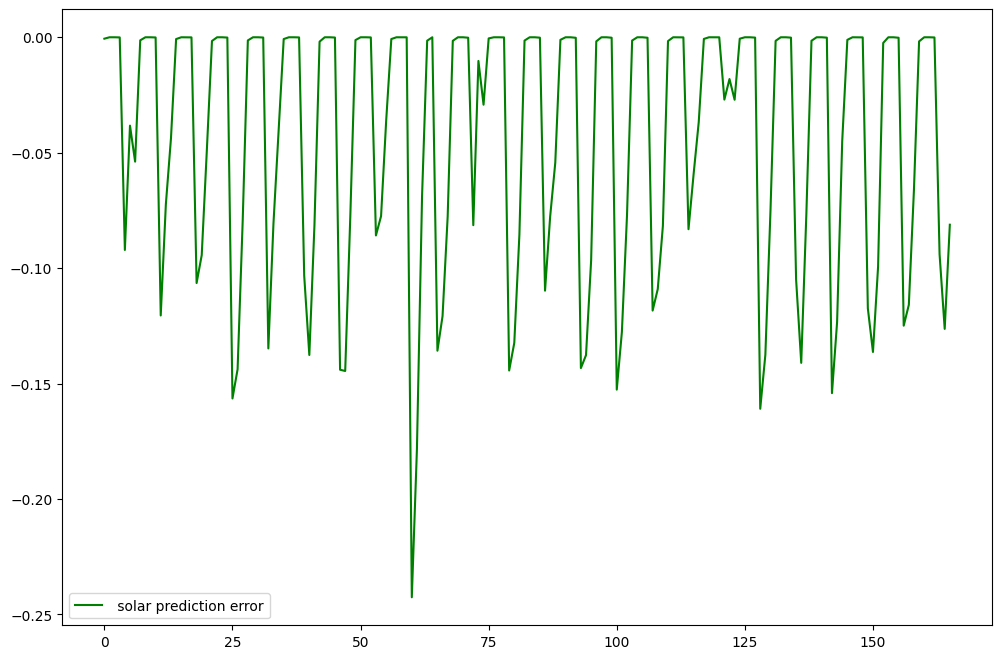

In [84]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(int(len(mean_test_predictions)/10)),mean_test_predictions[:int(len(mean_test_predictions)/10),0]-Y_test[:int(len(Y_test)/10),0],color='green',label=' solar prediction error')
#plt.plot(np.arange(int(len(Y_test)/10)),Y_test[:int(len(Y_test)/10),0],color='blue',label='test data')
plt.legend()
plt.show()

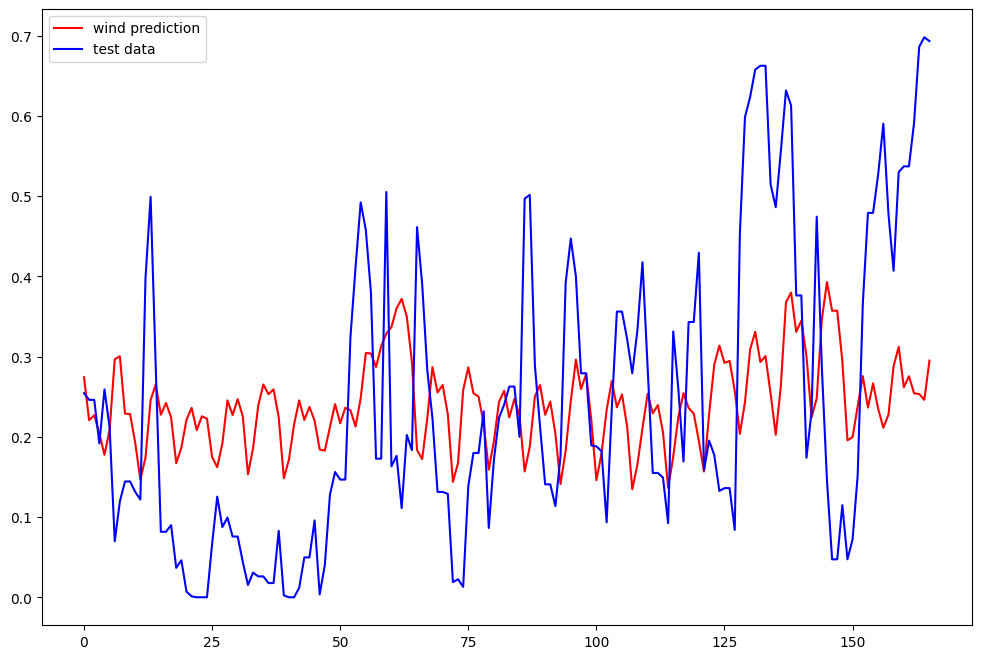

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(int(len(mean_test_predictions)/10)),mean_test_predictions[:int(len(mean_test_predictions)/10),1],color='red',label='wind prediction')
plt.plot(np.arange(int(len(Y_test)/10)),Y_test[:int(len(Y_test)/10),1],color='blue',label='test data')
plt.legend()
plt.show()

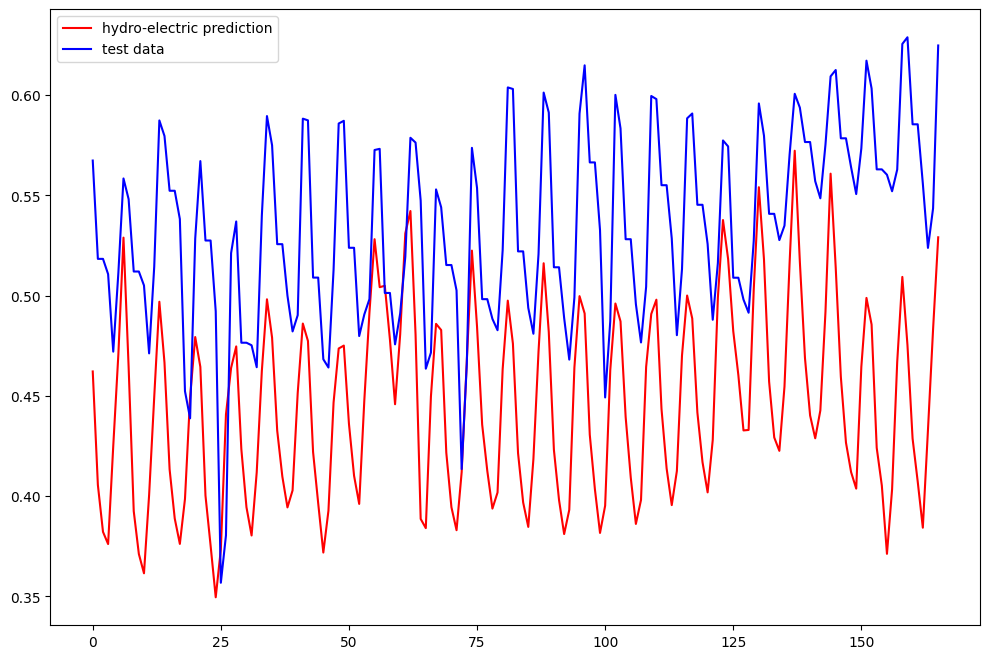

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(int(len(mean_test_predictions)/10)),mean_test_predictions[:int(len(mean_test_predictions)/10),2],color='red',label='hydro-electric prediction')
plt.plot(np.arange(int(len(Y_test)/10)),Y_test[:int(len(Y_test)/10),2],color='blue',label='test data')
plt.legend()
plt.show()

## GRID SEARCH WITH K-FOLD CROSS VALIDATION

In [113]:
import optuna
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit

# here we perform a grid search to look for the best hyperparameters: we choose to use 4 folds. We fix as objective to minimize the average validation error over the folds
# To compute each loss estimation before udating the weights, we perform 100 evaluations of the predicted outputs and consider their average as prediction

def get_activation(name):
        return {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "leaky_relu": nn.LeakyReLU()}[name]

def objective(trial):
    # hyperparameter search space
    hidden_dim1 = trial.suggest_int("hidden_dim1",8,40, step=4)
    hidden_dim2 = trial.suggest_int("hidden_dim2",8,40, step=4)
    latent_dim = trial.suggest_int("latent_dim",4,16, step=2)
    N1 = trial.suggest_int("N1", 4,16,step=4)
    N2 = trial.suggest_int("N2", 4,16,step=4)
    lambda_tik = trial.suggest_loguniform("lambda_tik", 1e-6, 1e-2)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # activation function selection
    act_name = trial.suggest_categorical("activation", ["relu", "sigmoid", "leaky_relu"])

    activation_fn = get_activation(act_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_epochs = 20
    epoch_train_losses = np.zeros(num_epochs)
    epoch_val_losses = np.zeros(num_epochs)
    epoch_val_vae_losses = np.zeros(num_epochs)
    epoch_val_regr_losses = np.zeros(num_epochs)

    batch_size = 32
    beta=1/30000
    num_folds=4
    tscv = TimeSeriesSplit(n_splits=num_folds)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_tensor)):

        X_train_fold, Y_train_fold = X_train_tensor[train_idx], Y_train_tensor[train_idx]
        X_val_fold, Y_val_fold = X_train_tensor[val_idx], Y_train_tensor[val_idx]

        train_dataset = TensorDataset(X_train_fold, Y_train_fold)
        val_dataset = TensorDataset(X_val_fold, Y_val_fold)

        train_dataset = TensorDataset(X_train_fold, Y_train_fold)
        val_dataset = TensorDataset(X_val_fold, Y_val_fold)

        model = VAE_Regression(
        input_dim=X_train_fold.shape[1],
        hidden_dim1=hidden_dim1,
        latent_dim=latent_dim,
        hidden_dim2=hidden_dim2,
        vae_activation=activation_fn,
        N1=N1,
        N2=N2,
        No=Y_train_fold.shape[1],
        activation=activation_fn,
        lambda_tik=lambda_tik).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(num_epochs):

            model.train()
            train_loss_epoch = 0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                n=1
                train_out=[]
                train_recon_x=[]
                for i in range(n):
                  regr_output, recon_x, mu, logvar, _ = model(x_batch)
                  train_out.append(regr_output)
                  train_recon_x.append(recon_x)

                train_out_tensor = torch.stack(train_out)
                train_recon_x_tensor = torch.stack(train_recon_x)

                mean_regr_output = train_out_tensor.mean(dim=0)
                mean_recon_x = train_recon_x_tensor.mean(dim=0)

                vae_loss = model.VAE_loss(mean_recon_x, x_batch, mu, logvar)[0]
                regr_loss = model.regression_loss(y_batch, mean_regr_output, lambda_tik)


                loss = 0.5*regr_loss + 0.5*beta*vae_loss
                loss.backward()
                optimizer.step()

                train_loss_epoch += loss.item()

            train_loss_epoch /= len(train_loader)
            #beta = regr_loss/vae_loss

            # validation

            model.eval()
            val_loss_epoch = 0.
            val_vae_loss_epoch=0.
            val_regr_loss_epoch=0.

            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    val_out=[]
                    val_recon_x=[]
                    for i in range(n):
                      regr_output, recon_x, mu, logvar, _ = model(x_batch)
                      val_out.append(regr_output)
                      val_recon_x.append(recon_x)

                    val_out_tensor = torch.stack(val_out)
                    val_recon_x_tensor = torch.stack(val_recon_x)

                    mean_regr_output = val_out_tensor.mean(dim=0)
                    mean_recon_x = val_recon_x_tensor.mean(dim=0)

                    vae_loss = model.VAE_loss(mean_recon_x, x_batch, mu, logvar)[0]
                    regr_loss = model.regression_loss(y_batch, mean_regr_output, lambda_tik)

                    val_loss = 0.5*regr_loss + 0.5*beta*vae_loss

                    val_loss_epoch += val_loss.item()
                    val_vae_loss_epoch += vae_loss.item()
                    val_regr_loss_epoch += regr_loss.item()

            val_loss_epoch /= len(val_loader)
            val_vae_loss_epoch /= len(val_loader)
            val_regr_loss_epoch /= len(val_loader)

            epoch_train_losses[epoch] += (train_loss_epoch)/num_folds
            epoch_val_losses[epoch] += (val_loss_epoch)/num_folds
            epoch_val_vae_losses[epoch] += (val_vae_loss_epoch)/num_folds
            epoch_val_regr_losses[epoch] += (val_regr_loss_epoch)/num_folds

    trial.set_user_attr("mean_train_loss_curve", epoch_train_losses.tolist())
    trial.set_user_attr("mean_val_loss_curve", epoch_val_losses.tolist())
    trial.set_user_attr("mean_val_vae_loss_curve", epoch_val_vae_losses.tolist())
    trial.set_user_attr("mean_val_regr_loss_curve", epoch_val_regr_losses.tolist())

    model_path = f"/home/best_model_trial_{trial.number}.pt"
    torch.save(model.state_dict(), model_path)
    trial.set_user_attr("model_path", model_path) # to later have the path of the best model

    return epoch_val_vae_losses[-1], epoch_val_regr_losses[-1]  # loss Optuna will minimize this with the hyper paramters search


In [114]:
study = optuna.create_study(directions=["minimize","minimize"],pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10))

from tqdm import tqdm
n_trials = 5
for _ in tqdm(range(n_trials), desc="Optuna Trials", unit="trial"):
    study.optimize(objective, n_trials=1,n_jobs=-1,catch=(Exception,))

[I 2025-05-21 08:18:14,955] A new study created in memory with name: no-name-cde75c0a-b6ac-41f6-ab42-017fe37b7ba7
Optuna Trials:   0%|          | 0/5 [00:00<?, ?trial/s]<ipython-input-113-968ed7e01e06>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_tik = trial.suggest_loguniform("lambda_tik", 1e-6, 1e-2)
<ipython-input-113-968ed7e01e06>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-05-21 08:19:01,054] Trial 0 finished with values: [669.507535117013, 0.05789880291558802] and parameters: {'hidden_dim1': 12, 'hidden_dim2': 24, 'latent_dim': 6, 'N1': 12, 'N2': 12, 'lambda_tik': 6.958523747173644e-06, 'lr'

In [95]:
import json
# get best hyperparameters
best_params = study.best_trial.params
best_activation = get_activation(best_params["activation"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rebuild the model with best hyperparameters
best_model = VAE_Regression(
    input_dim=X_train_tensor.shape[1],
    hidden_dim1=best_params["hidden_dim1"],
    latent_dim=best_params["latent_dim"],
    hidden_dim2=best_params["hidden_dim2"],
    vae_activation=best_activation,
    N1=best_params["N1"],
    N2=best_params["N2"],
    No=Y_train_tensor.shape[1],
    activation=best_activation,
    lambda_tik=best_params["lambda_tik"]
).to(device)

# load the weights of the best trial
best_model.load_state_dict(torch.load(study.best_trial.user_attrs["model_path"]))

# Ora puoi salvare questo modello definitivo
torch.save(best_model.state_dict(), "/home/best_model_overall.pt")


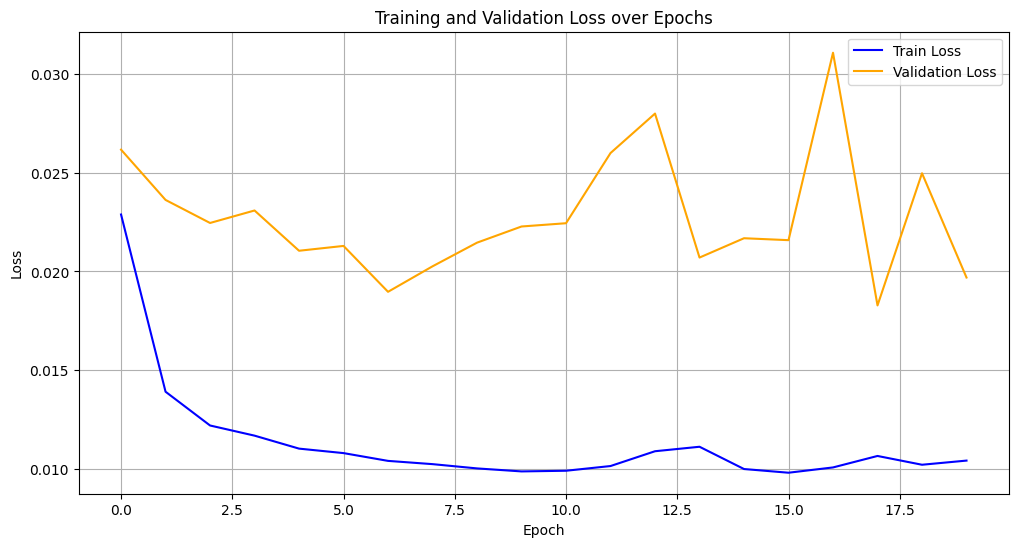

In [96]:
pareto_trials = study.best_trials

# plot training and validation losses over epochs

train_loss_curve = np.array(best_trial.user_attrs["mean_train_loss_curve"])
val_loss_curve = np.array(best_trial.user_attrs["mean_val_loss_curve"])
val_vae_loss_curve = np.array(best_trial.user_attrs["mean_val_vae_loss_curve"])
val_regr_loss_curve = np.array(best_trial.user_attrs["mean_val_regr_loss_curve"])

epochs = np.arange(len(train_loss_curve))

plt.figure(figsize=(12, 6))

plt.plot(epochs, train_loss_curve, label='Train Loss', color='blue')
plt.plot(epochs, val_loss_curve, label='Validation Loss', color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

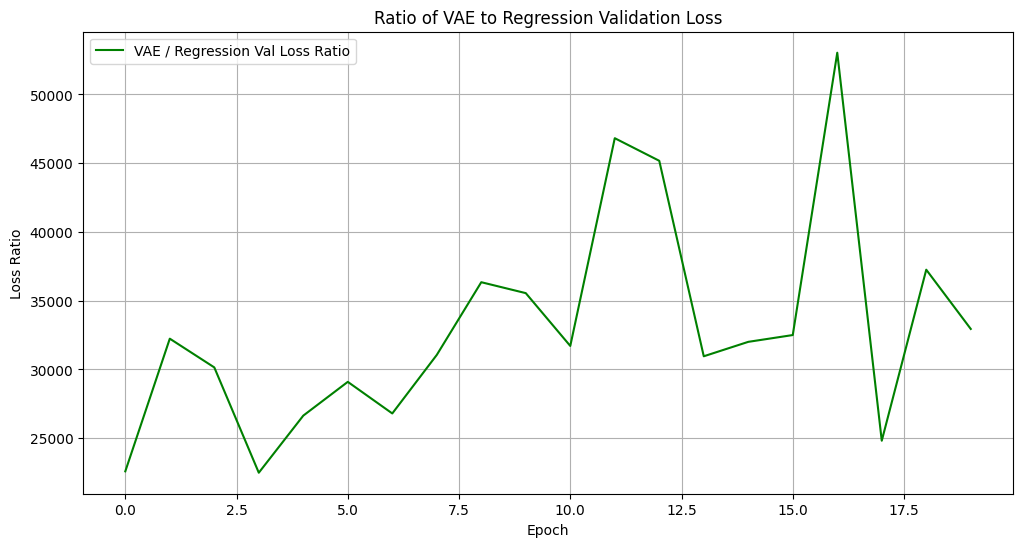

In [97]:
loss_ratio = val_vae_loss_curve / (val_regr_loss_curve + 1e-8)  # avoid division by zero

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_ratio, label='VAE / Regression Val Loss Ratio', color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss Ratio")
plt.title("Ratio of VAE to Regression Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


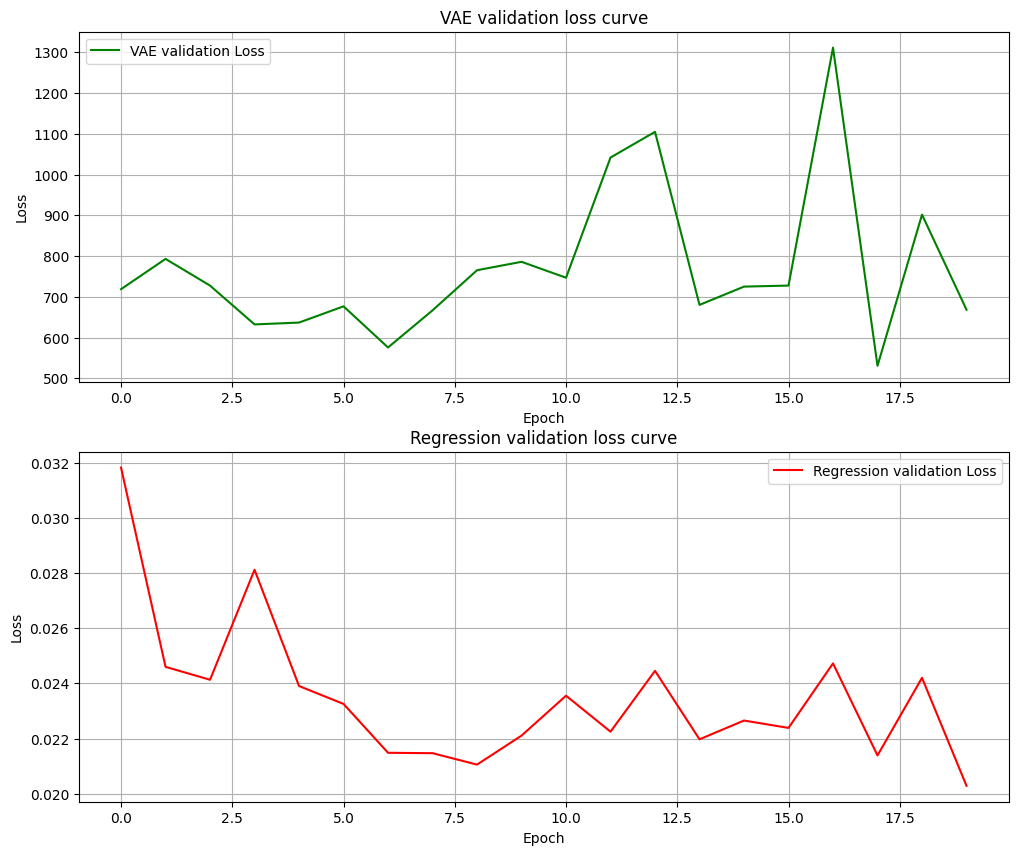

In [111]:
fig,ax= plt.subplots(figsize=(12, 10),nrows=2,ncols=1)

ax[0].plot(epochs, val_vae_loss_curve, label='VAE validation Loss', color='green')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("VAE validation loss curve")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(epochs, val_regr_loss_curve, label='Regression validation Loss', color='red')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Regression validation loss curve")
ax[1].grid(True)
ax[1].legend()
plt.show()


[[0.02771152 0.10651855 0.36997342]
 [0.01804462 0.11565222 0.3602941 ]
 [0.01715813 0.12177359 0.35386327]
 ...
 [0.02061971 0.29099488 0.22040686]
 [0.01718454 0.3155805  0.2067623 ]
 [0.01795454 0.30822158 0.2106281 ]]


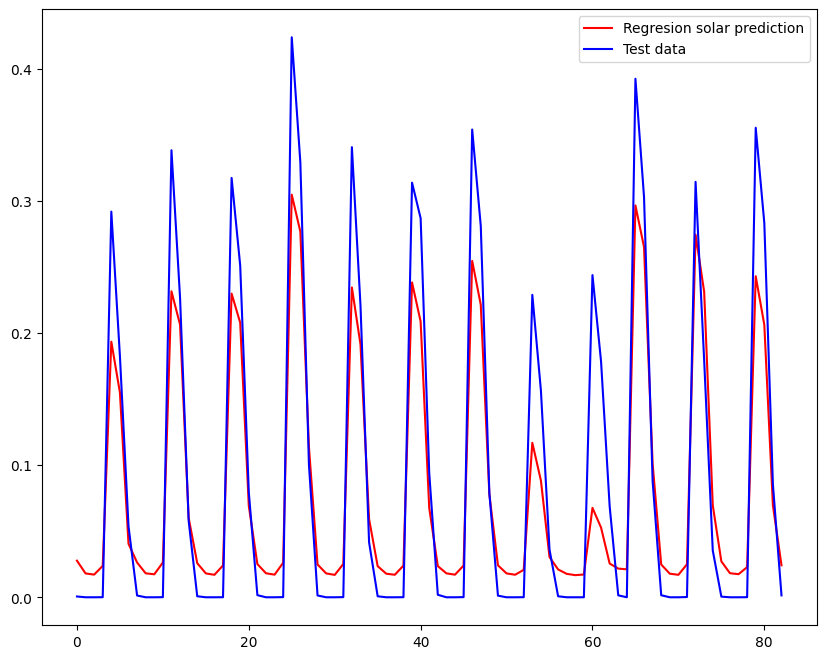

In [98]:
#best_params = study.best_trial.params
activation_fn = get_activation(best_params["activation"])

#best_model = VAE_Regression(
#    input_dim=X_train_tensor.shape[1],
#    hidden_dim1=best_params["hidden_dim1"],
#    latent_dim=best_params["latent_dim"],
#    hidden_dim2=best_params["hidden_dim2"],
#    vae_activation=activation_fn,
#    N1=best_params["N1"],
#    N2=best_params["N2"],
#    No=Y_train_tensor.shape[1],
#    activation=activation_fn,
#    lambda_tik=best_params["lambda_tik"]
#).to(device)
#

best_model.eval()

test_predictions=[]
recon_x_vec= []
with torch.no_grad(): # Disable gradient calculation for inference
    for i in range(10000):
      regr_output, reconstructed_x, mu, logvar, z = best_model(X_test_tensor.to(device))
      test_predictions.append(regr_output)
      recon_x_vec.append(reconstructed_x)

test_predictions_tensor = torch.stack(test_predictions)
reconstructed_x_tensor = torch.stack(recon_x_vec)

# move the output to CPU and convert to numpy array for printing/analysis

test_predictions = test_predictions_tensor.cpu().numpy().mean(axis=0)
z = z.cpu().numpy()


recon_x_test = reconstructed_x_tensor.cpu().numpy().mean(axis=0)


print(test_predictions)

#train_predictions = regr_output_train.cpu().numpy()
#z_train = z_train.cpu().numpy()
#recon_x_train = reconstructed_x_train.cpu().numpy()



# regression test prediction vs test data

plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(test_predictions)/20)),test_predictions[:int(len(test_predictions)/20),0],color='red',label='Solar production prediction')
plt.plot(np.arange(int(len(Y_test)/20)),Y_test[:int(len(Y_test)/20),0],color='orange',label='Test data')
plt.legend()
plt.show()



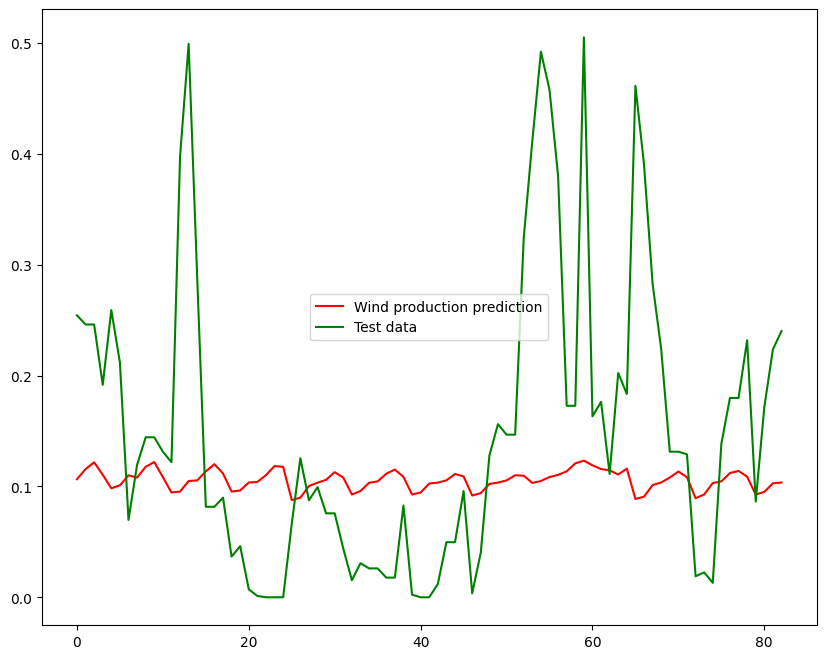

In [105]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(test_predictions)/20)),test_predictions[:int(len(test_predictions)/20),1],color='red',label='Wind production prediction')
plt.plot(np.arange(int(len(Y_test)/20)),Y_test[:int(len(Y_test)/20),1],color='green',label='Test data')
plt.legend()
plt.show()



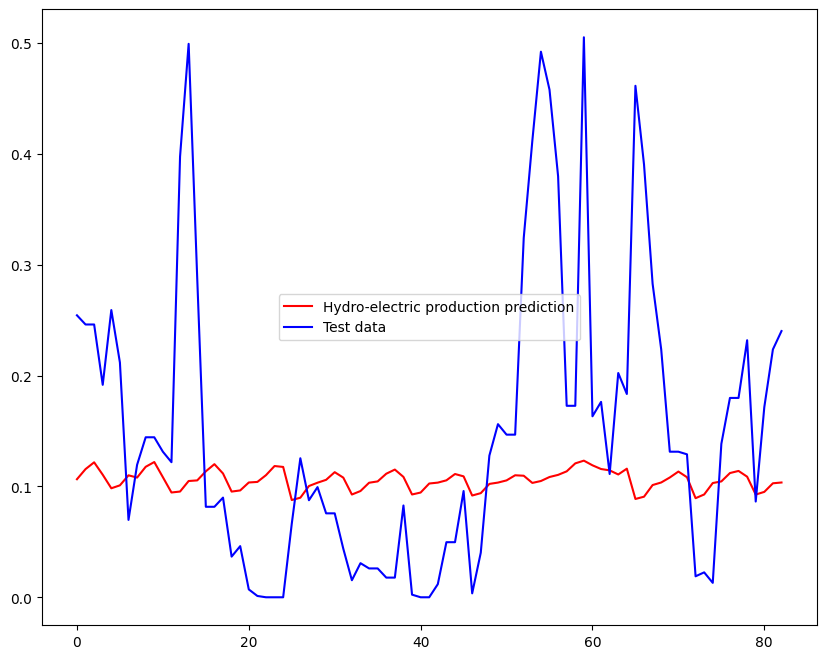

In [106]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(test_predictions)/20)),test_predictions[:int(len(test_predictions)/20),1],color='red',label='Hydro-electric production prediction')
plt.plot(np.arange(int(len(Y_test)/20)),Y_test[:int(len(Y_test)/20),1],color='blue',label='Test data')
plt.legend()
plt.show()

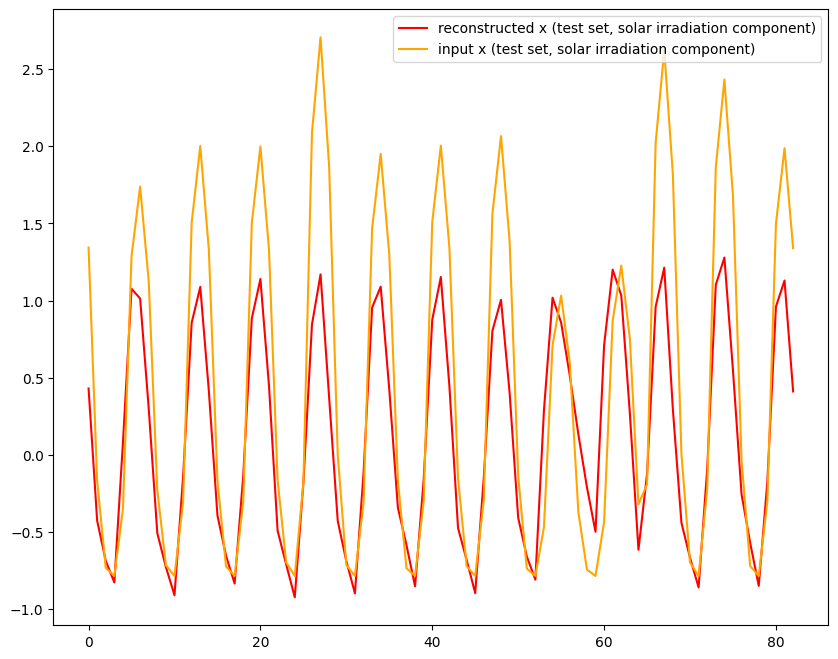

In [102]:
#Input reconstruction: visualization
plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(recon_x_test)/20)),recon_x_test[:int(len(recon_x_test)/20),2],color='red',label='reconstructed x (test set, solar irradiation component)')
plt.plot(np.arange(int(len(recon_x_test)/20)),X_test[:int(len(recon_x_test)/20),2],color='orange',label='input x (test set, solar irradiation component)')

plt.legend()
plt.show()

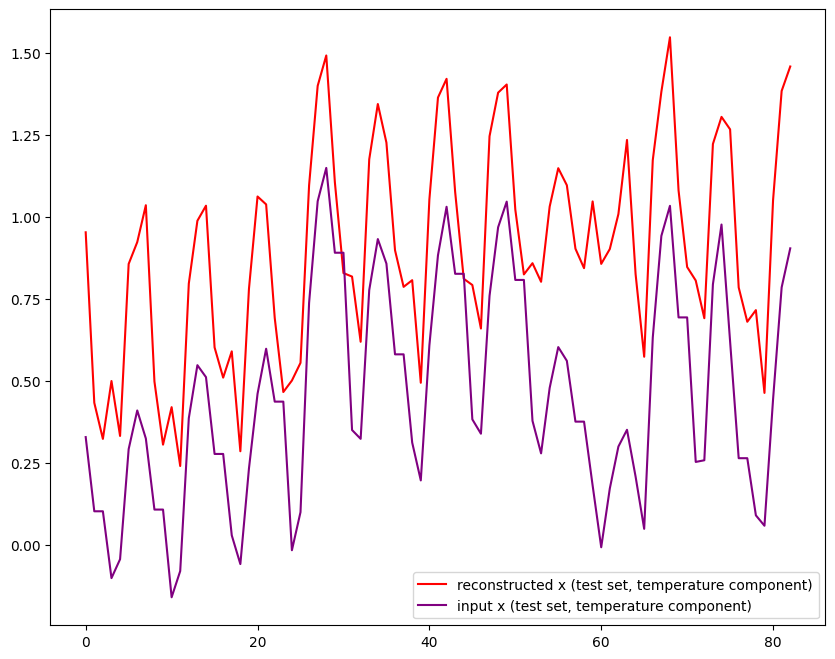

In [104]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(recon_x_test)/20)),recon_x_test[:int(len(recon_x_test)/20),1],color='red',label='reconstructed x (test set, temperature component)')
plt.plot(np.arange(int(len(recon_x_test)/20)),X_test[:int(len(recon_x_test)/20),1],color='purple',label='input x (test set, temperature component)')

plt.legend()
plt.show()

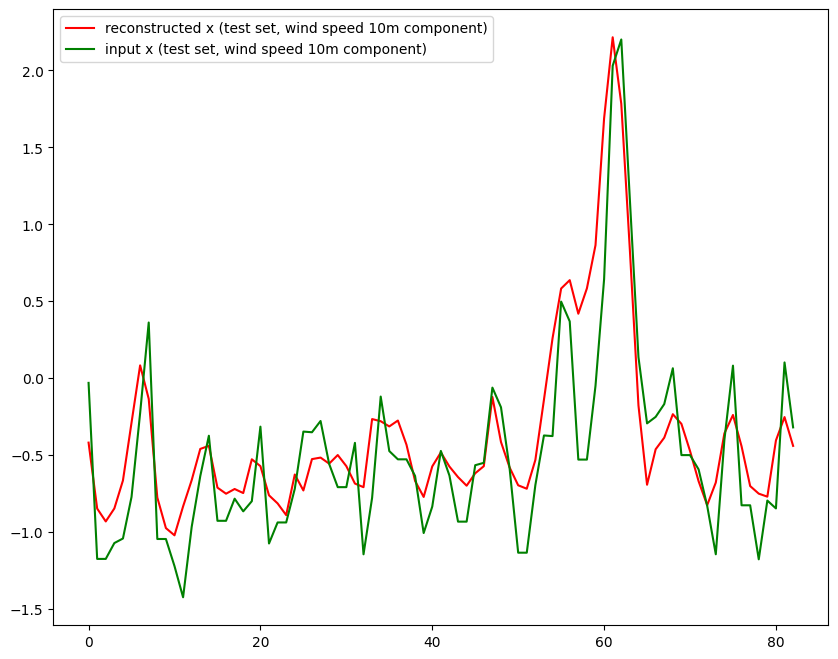

In [103]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(int(len(recon_x_test)/20)),recon_x_test[:int(len(recon_x_test)/20),4],color='red',label='reconstructed x (test set, wind speed 10m component)')
plt.plot(np.arange(int(len(recon_x_test)/20)),X_test[:int(len(recon_x_test)/20),4],color='green',label='input x (test set, wind speed 10m component)')

plt.legend()
plt.show()

In [101]:
test_vae_loss, recon_loss_test, kl_div_test = best_model.VAE_loss(
    reconstructed_x, X_test_tensor.to(device), mu, logvar)

test_regr_loss = best_model.regression_loss(
    Y_test_tensor, regr_output, best_params["lambda_tik"]
)

#total_test_loss = best_params["beta"] * test_vae_loss + test_regr_loss

print(f"Test VAE Loss: {test_vae_loss.item():.4f}")
print(f"  - Reconstruction Loss: {recon_loss_test.item():.4f}")
print(f"  - KL Divergence: {kl_div_test.item():.4f}")
print(f"Test Regression Loss: {test_regr_loss.item():.4f}")

Test VAE Loss: 42149.1562
  - Reconstruction Loss: 29922.8574
  - KL Divergence: 12226.2988
Test Regression Loss: 0.0198
